### This notebook trains a classifier that classifiers color identity from card art

## Load and format data

In [ ]:
from pathlib import Path
import requests
import time
import pandas as pd
import numpy as np
!pip install fastai --upgrade
!pip install fastcore --upgrade
from fastai.vision.all import *

In [ ]:
df = pd.read_csv('cards.csv')
# df.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,12,16,19,40,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = df[['name', 'artist', 'colorIdentity', 'types']]
df.head()

,name,artist,colorIdentity,types
0,Abundance,Rebecca Guay,G,Enchantment
1,Academy Researchers,Stephen Daniele,U,Creature
2,Adarkar Wastes,John Avon,"U,W",Land
3,Afflict,Roger Raupp,B,Instant
4,Aggressive Urge,Christopher Moeller,G,Instant


In [ ]:
df = df.groupby('types').filter(lambda x: len(x) > 10)
df.shape

(43830, 4)

In [ ]:
df['colorIdentity'].fillna('C', inplace=True)
# df['colorIdentity'].value_counts()

## Download card art

In [ ]:
w_path = Path('W')
u_path = Path('U')
b_path = Path('B')
r_path = Path('R')
g_path = Path('G')
c_path = Path('C')

for p in [w_path, u_path, b_path, r_path, g_path, c_path]:
    if not p.exists():
        p.mkdir()

In [ ]:
def get_art_url(card_name):
    resp = requests.get(fr'https://api.scryfall.com/cards/named?exact={card_name}').json()
    art_url = ""
    image_uris = resp.get('image_uris')
    if image_uris:
        art_url = image_uris.get('art_crop')
    return art_url

In [ ]:
df.shape

(43830, 4)

Before each download, shuffle dataset to get a good mix of old & new art. across different sets

Note that since the complete dataset is massive, it's recommended to only download ~1-10% of the dataset which should be sufficient for transfer learning. This is still a sizable dataset however and will take a long time to download.

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
n_total = df.shape[0]
n_downloaded = 0

for _, row in df.iterrows():
    # Get all colors in ColorID
    color_val = row['colorIdentity']
    if len(color_val) > 1:
        color_val = [c for c in color_val if c != ',']
    else:
        color_val = [color_val]

    # Download card art for each card/color. Note that if a card
    # has a colorID w/ len>1, will store a copy in all associated
    # colors
    for color in color_val:
        path = f"{color}/{row['name']}-{row['artist']}.jpg"
        uri = get_art_url(row['name'])
        if uri:
            im_resp = requests.get(uri, stream=True)
        try:
            with open(path, "wb") as f:
                f.write(im_resp.content)
                print(f"{round(n_downloaded/n_total, 3)}% Downloaded {path}")
                n_downloaded += 1
                time.sleep(0.05)
        except FileNotFoundError:
            print(f"{round(n_downloaded/n_total, 3)}% FAILED {path}")

In [ ]:
w_ims = len(list(w_path.glob("*")))
u_ims = len(list(u_path.glob("*")))
b_ims = len(list(b_path.glob("*")))
r_ims = len(list(r_path.glob("*")))
g_ims = len(list(g_path.glob("*")))
c_ims = len(list(c_path.glob("*")))

print(f"W ims: {w_ims}")
print(f"U ims: {u_ims}")
print(f"B ims: {b_ims}")
print(f"R ims: {r_ims}")
print(f"G ims: {g_ims}")
print(f"C ims: {c_ims}")
print(f"Total ims: {w_ims + u_ims + b_ims + r_ims + g_ims + c_ims}")

W ims: 687
U ims: 694
B ims: 685
R ims: 704
G ims: 722
C ims: 373
Total ims: 3865


In [ ]:
# Tar images for downloading

# !tar -cvf W.tar W/
# !tar -cvf U.tar U/
# !tar -cvf B.tar B/
# !tar -cvf R.tar R/
# !tar -cvf G.tar G/
# !tar -cvf C.tar C/

## Setup model

In [ ]:
df['im_path'] = df['colorIdentity'].astype(str).str[0] + '/' + df['name'] + '-' + df['artist'] + '.jpg'
df = df.dropna()
df.head()

,name,artist,colorIdentity,types,im_path
36338,Sire of Stagnation,Tyler Jacobson,"B,U",Creature,B/Sire of Stagnation-Tyler Jacobson.jpg
7163,Plated Crusher,Jama Jurabaev,G,Creature,G/Plated Crusher-Jama Jurabaev.jpg
35481,Gilt-Leaf Winnower,Viktor Titov,B,Creature,B/Gilt-Leaf Winnower-Viktor Titov.jpg
14168,Juniper Order Ranger,Greg Hildebrandt,"G,W",Creature,G/Juniper Order Ranger-Greg Hildebrandt.jpg
13034,Illusion of Choice,John Severin Brassell,U,Instant,U/Illusion of Choice-John Severin Brassell.jpg


In [ ]:
df['data_downloaded'] = False
for idx, row in df.iterrows():
    if Path(row['im_path']).exists():
        df.at[idx, 'data_downloaded'] = True
df.shape

(43830, 6)

In [ ]:
df['data_downloaded'].value_counts()

False    32014
True     11816
Name: data_downloaded, dtype: int64

In [ ]:
df = df[df['data_downloaded'] == True]
df.shape

(11816, 6)

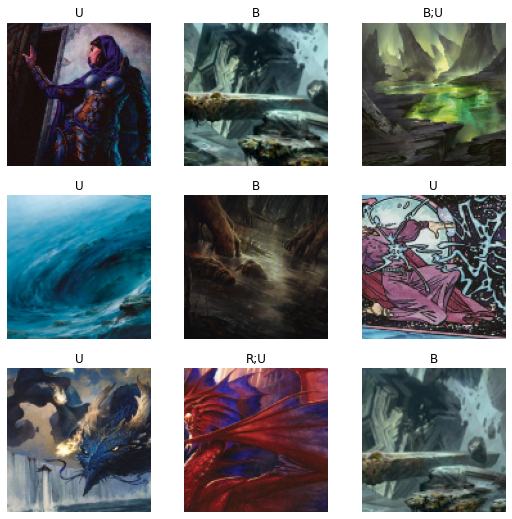

In [ ]:
def get_im_files(r):
    return r['im_path']

def get_color_ids(r):
    return r['colorIdentity'].split(',')

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    get_x=get_im_files,
                    get_y=get_color_ids,
                    splitter=RandomSplitter(),
                    item_tfms=Resize(450),
                    batch_tfms=aug_transforms(size=112, min_scale=0.75))

dls = dblock.dataloaders(df)
dls.show_batch()

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 112, 112]), torch.Size([64, 6]))

## Train first model

In [ ]:
model = cnn_learner(dls, resnet18, loss_func=torch.nn.BCEWithLogitsLoss(), metrics=accuracy_multi)
# model.lr_find() 3e-3

In [ ]:
model.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.508995,0.336614,0.861687,01:17
1,0.353167,0.287151,0.881577,01:16
2,0.312301,0.275560,0.886021,01:16


SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=6.309573450380412e-07)

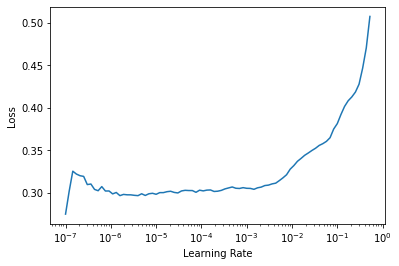

In [ ]:
model.unfreeze()
model.lr_find()

In [ ]:
model.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.303764,0.273389,0.887784,01:17
1,0.295262,0.262688,0.891593,01:17
2,0.282468,0.249037,0.900973,01:17
3,0.268640,0.237221,0.907321,01:17
4,0.259463,0.227096,0.910284,01:17
5,0.251871,0.218709,0.914375,01:18
6,0.237994,0.214573,0.915574,01:18
7,0.237994,0.211965,0.917901,01:17
8,0.235818,0.210885,0.917831,01:18
9,0.230778,0.210663,0.917972,01:17


Surprisingly accuracy still increasing semi steadily!

In [ ]:
model.fit_one_cycle(5, lr_max=slice(1e-6, 3e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.226379,0.201971,0.922486,01:15
1,0.219529,0.185969,0.929045,01:15
2,0.204568,0.175234,0.934053,01:15
3,0.191659,0.170145,0.935745,01:14
4,0.184387,0.170179,0.934970,01:13


Think we can go for a few more epochs, training/validation loss going down still

In [ ]:
model.fit_one_cycle(5, lr_max=slice(1e-6, 3e-4))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.180929,0.167344,0.936451,01:15
1,0.176823,0.155808,0.942799,01:15
2,0.161919,0.148708,0.946607,01:15
3,0.150588,0.145844,0.946678,01:15
4,0.147818,0.144190,0.947736,01:15


Pretty impressed with how this turned out!

In [ ]:
model.save('mtg_art_classifier')

Path('models/mtg_art_classifier.pth')